# 予備実験

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 発話分類

In [92]:
from sklearn.metrics import accuracy_score

In [93]:
%load_ext tensorboard
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [94]:
import tensorflow_datasets as tfds
import tensorflow as tf
import datetime
from tensorflow.keras.callbacks import TensorBoard

## データセット

In [95]:
#train_dataset_path = "drive/My Drive/研究/swda_data/train_set.txt"
#test_dataset_path = "drive/My Drive/研究/swda_data/test_set.txt"
train_dataset_path = "drive/My Drive/研究/swda_data/train_dataset.txt"
val_dataset_path = "drive/My Drive/研究/swda_data/val_set.txt"
full_dataset_path = "drive/My Drive/研究/swda_data/full_set.txt"
vacab_list_path = "drive/My Drive/研究/swda_data/vocabulary.txt"

In [53]:
"""
train_dataset_path = "../Switchboard-Corpus/swda_data/train_set.txt"
test_dataset_path = "../Switchboard-Corpus/swda_data/test_set.txt"
val_dataset_path = "../Switchboard-Corpus/swda_data/val_set.txt"
"""

'\ntrain_dataset_path = "../Switchboard-Corpus/swda_data/train_set.txt"\ntest_dataset_path = "../Switchboard-Corpus/swda_data/test_set.txt"\nval_dataset_path = "../Switchboard-Corpus/swda_data/val_set.txt"\n'

In [54]:
train_dataset = []
f = open(train_dataset_path, "r", encoding='utf-8')
for row in f:
    train_dataset.append(row.strip())
f.close()

In [55]:
val_dataset = []
f = open(val_dataset_path, "r", encoding='utf-8')
for row in f:
    val_dataset.append(row.strip())
f.close()

In [56]:
"""
test_dataset = []
f = open(test_dataset_path, "r", encoding='utf-8')
for row in f:
    test_dataset.append(row.strip())
f.close()
"""

'\ntest_dataset = []\nf = open(test_dataset_path, "r", encoding=\'utf-8\')\nfor row in f:\n    test_dataset.append(row.strip())\nf.close()\n'

In [96]:
full_dataset = []
f = open(full_dataset_path, "r", encoding='utf-8')
for row in f:
    full_dataset.append(row.strip())
f.close()

In [58]:
"""
vocab_list = []
f = open(vacab_list_path, "r", encoding='utf-8')
for row in f:
  vocab_list.append(row.split("\n")[0])
f.close()
"""

'\nvocab_list = []\nf = open(vacab_list_path, "r", encoding=\'utf-8\')\nfor row in f:\n  vocab_list.append(row.split("\n")[0])\nf.close()\n'

### データセット分割

In [59]:
## 訓練データ
train_utter_user = []
train_utter = []
train_utter_label = []

## テストデータ
test_utter_user = []
test_utter = []
test_utter_label = []

## 検証データ
val_utter_user = []
val_utter = []
val_utter_label = []

## フルデータ
full_utter_user = []
full_utter = []
full_utter_label = []


In [83]:
non_remove_labels = ["sd", "b", "sv", "%", "aa", "ba", "qy", "ny", "fc"]

In [60]:
for j in train_dataset:
    for i,v in enumerate(j.split("|")):
        if i == 0:
            train_utter_user.append(v)
        elif i==1:
            train_utter.append(v)
        else:
            train_utter_label.append(v)
            
print("finish")

finish


In [61]:
"""
for j in test_dataset:
    for i,v in enumerate(j.split("|")):
        if i == 0:
            test_utter_user.append(v)
        elif i==1:
            test_utter.append(v)
        else:
            test_utter_label.append(v)
            
print("finish")
"""

'\nfor j in test_dataset:\n    for i,v in enumerate(j.split("|")):\n        if i == 0:\n            test_utter_user.append(v)\n        elif i==1:\n            test_utter.append(v)\n        else:\n            test_utter_label.append(v)\n            \nprint("finish")\n'

In [62]:
for j in val_dataset:
    for i,v in enumerate(j.split("|")):
        if i == 0:
            val_utter_user.append(v)
        elif i==1:
            val_utter.append(v)
        else:
            val_utter_label.append(v)
            
print("finish")

finish


In [97]:
for j in full_dataset:
    for i,v in enumerate(j.split("|")):
        if i == 0:
            full_utter_user.append(v)
        elif i==1:
            full_utter.append(v)
        else:
            full_utter_label.append(v)
            
print("finish")

finish


In [99]:
for i,v in enumerate(full_utter_label):
  if v=="b":
    print(full_utter[i])

ストリーミング出力は最後の 5000 行に切り捨てられました。
that's true.
Yeah,
Okay,
I agree with you
Yeah.
yeah.
It's not, it's not quite the bargain that .
yeah,
that's true.
Right.
Yeah.
Yeah.
I bet that would be, rather interesting.
Yes.
Sure.
Oh, yeah,
Exactly, exactly right.
Uh, this is true.
That's right,
that's right.
Yeah.
Yeah,
yeah,
It really is.
yeah.
Yeah,
Yeah,
right.
Yeah.
Yeah,
right
yes,
Yes,
yes.
That's right.
That's right.
Okay,
Yeah,
Absolutely,
Oh no,
no,
Yeah,
that's right.
Well, I do to, uh,
Oh yes,
Oh, I do too.
Oh of course,
of course.
Yeah,
Yeah,
Oh yeah,
sure.
That's right.
They sure are.
Absolutely.
Oh, there sure is
Uh-huh,
that's right.
That's right,
That's right,
That's right.
That's right,
No,
no,
Yeah,
that's right.
Oh, they do.
Oh, yeah,
Oh, definitely.
Yeah,
Right,
exactly.
Right,
Okay,
sure,
True.
Yeah,
I think that's true.
Yeah,
I would agree with that.
Uh-huh,
that's true.
Exactly,
Yeah,
No.
I don't think so either.
Yeah.
I agree,
Sure,
Exactly.
Yes,
yeah.
Yeah
I know.
Yes,
S

In [64]:
for i,v in enumerate(full_utter_label):
  if v=="fa":
    print(full_utter[i])

I'm sorry.
I'm so sorry.
I'm sorry,
I'm sorry.
sorry,
excuse me.
I hate to do it on this call.
I'm sorry,
I'm sorry I keep coughing.
I am sorry.
is talking to someone in Sorry.
Thanks.
sorry.
Excuse me.
sorry.
I'm sorry
Oh, I'm sorry
sorry about that
I'm sorry, this, I really feel strongly about this.
Didn't mean to cut you off there.
thank you, I'm sorry, I just got home from work
Well, I'm sorry
I'm sorry
my mother, excuse me.
Sorry
excuse me.
I'm sorry,
I beg your pardon.
excuse me,
Sorry for the delay.
I'm sorry.
And primarily, I mean, I, now I'm probably going to, going to upset you.
Sorry.
the phone and talks to Sorry,
sorry.
I'm sorry,
I'm sorry, um
and I apologize if you're a bird lover,
Oh, I'm sorry.
Oh, I'm sorry.
Well anyway, I'm sorry
I'm sorry.
I'm sorry
I'm sorry to keep you waiting
Sorry I roped on Volvos then
Sorry I roped on Volvos then.
I'm sorry,
pardon the terminology,
I'm sorry.
I am so sorry to keep you on hold.
actually, I'm sorry, not until,
well, I'm sorry I i

In [84]:
for i,v in enumerate(full_utter_label):
  if v=="sv":
    print(full_utter[i])

ストリーミング出力は最後の 5000 行に切り捨てられました。
I think they ought to get on with something important.
they really make themselves look bad,
I think it's, it's kind of interesting that everybody's so busy politicking that the question is are we getting anything good done.
It's like this whole school issue.
and, and it all seems, you know, like everybody's trying to one-upmanship on everybody else
Well, there's been a lot of publicity lately about that new Nancy Reagan book out by, uh, Kitty Kelly, the unauthorized biography.
Well, I, the reason why I was thinking about looking at it is because it's supposed to,
and so it's supposed to have a lot of unflattering things in it.
but that one just sounded like gossipy.
And you have so many out there that, uh, that you, you know, you never get a chance to read.
something's excellent about them, whether it's the way they were written or whether it was the material they were written, you know, that was written about.
it seems like, uh, older people have much 

In [90]:
for i,v in enumerate(full_utter_label):
  if v=="ft":
    print(full_utter[i])

Well, thank you.
Thank you.
Thanks.
well, thank you.
Well, thank you.
Thanks.
Thanks.
an, and thanks for participating.
Well, thanks for calling for helping us out.
Thank you very much.
Oh. Thank you very much
Thanks for punching in
and thank you for calling.
Thank you very much.
Thank you.
well, thanks so much.
thank you.
Oh thanks
Uh, well, thank you.
Thank you.
Thanks,
Well I really appreciate all the helpful tips,
Thanks.
Thank you,
Thank you.
Thank you.
Thank you for noticing
Thank you.
Thank you.
Well thanks a lot.
Thank you,
thank you.
Thank you
thanks for that, uh, reference.
well, thank you very much.
thanks.
Oh, thank you.
And thanks for calling.
thanks a lot.
thanks and background
well thanks a bunch,
thank you,
Well, thanks,
Well, thank you.
Hey, well thanks for the call.
thanks.
hey thanks so much.
thank you,
Hey thanks a lot,
thank you,
Thanks.
Thanks for call.
Thank you to someone else in
thank you .
Thank you
Thank you.
Thank you.
Well thanks for being home, uh, on the 

### ラベルデータ数値化

In [66]:
from tensorflow.keras.utils import to_categorical

In [67]:
label_path = "drive/My Drive/研究/swda_data/metadata/labels.txt"
labels = []
f = open(label_path, "r", encoding='utf-8')
for row in f:
    labels.append(row.strip())
f.close()

In [68]:
label = {}
for i,v in enumerate(labels):
    label[v] = to_categorical(i, num_classes=len(labels))

In [69]:
train_utter_labels = []
for i in train_utter_label:
    train_utter_labels.append(label[i])

In [70]:
"""
test_utter_labels = []
for i in test_utter_label:
    test_utter_labels.append(label[i])
"""

'\ntest_utter_labels = []\nfor i in test_utter_label:\n    test_utter_labels.append(label[i])\n'

In [71]:
val_utter_labels = []
for i in val_utter_label:
    val_utter_labels.append(label[i])

## データセットをtensorflowに扱える形にする

In [72]:
train_data = tf.data.Dataset.from_tensor_slices((train_utter, train_utter_labels))
#test_data = tf.data.Dataset.from_tensor_slices((test_utter, test_utter_labels))
val_data = tf.data.Dataset.from_tensor_slices((val_utter, val_utter_labels))
#full_data = tf.data.Dataset.from_tensor_slices((full_utter))
#vocab_data = tf.data.Dataset.from_tensor_slices((vocab_list))

## トークナイザー

In [73]:
## ボキャブラリーリスト
vocabulary_set = set()
## トークナイザー
tokenizer = tfds.deprecated.text.Tokenizer()

full_data_list = [train_data, val_data]

## 分かち書き
for i in full_data_list:
  for j,_ in i:
    some_tokens = tokenizer.tokenize(j.numpy())
    vocabulary_set.update(some_tokens)
    
## ボキャブラリーリスト作成
vocab_size = len(vocabulary_set)

## encode生成

In [74]:
encoder = tfds.deprecated.text.TokenTextEncoder(vocabulary_set)

In [75]:
def encode(token, label):
    token = encoder.encode(token.numpy())
    return token, label

@tf.function
def tf_encoder(utter, label):
    encoded_text, label = tf.py_function(encode,[utter, label],[tf.int64, tf.float32])
    encoded_text.set_shape([None])
    return encoded_text, label


## metrics

In [76]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

## データ設計

In [77]:
max_len = 40

In [78]:
all_train_data_encode = train_data.map(tf_encoder)
#all_test_data_encode = test_data.map(tf_encoder)
all_val_data_encode = val_data.map(tf_encoder)

In [79]:
test_size = 30000
all_train = all_train_data_encode.skip(test_size)
all_test = all_train_data_encode.take(test_size)

In [80]:
utter_train_data = all_train.padded_batch(64, padded_shapes=([None], [41]), drop_remainder=True)
utter_test_data = all_test.padded_batch(64, padded_shapes=([None], [41]), drop_remainder=True)
utter_val_data = all_val_data_encode.padded_batch(64, padded_shapes=([None], [41]), drop_remainder=True)

In [81]:
utter_train_data, utter_test_data, utter_val_data

(<PaddedBatchDataset shapes: ((64, None), (64, 41)), types: (tf.int64, tf.float32)>,
 <PaddedBatchDataset shapes: ((64, None), (64, 41)), types: (tf.int64, tf.float32)>,
 <PaddedBatchDataset shapes: ((64, None), (64, 41)), types: (tf.int64, tf.float32)>)

## モデル設計(RNN)

In [ ]:
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import RMSprop

In [ ]:
rnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(22302, 64),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(41, activation='softmax')
])

In [ ]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          1427328   
_________________________________________________________________
gru (GRU)                    (None, 64)                24960     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 41)                2665      
Total params: 1,459,113
Trainable params: 1,459,113
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rnn_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=generate_metrics())

In [ ]:
history = rnn_model.fit(utter_train_data, epochs=40,
                    validation_data=utter_val_data,
                    validation_steps=30,
                    callbacks=[TensorBoard()])

Epoch 1/14
   1/2601 [..............................] - ETA: 3s - loss: 3.7132 - accuracy: 0.0000e+00 - acc-0: 0.5000 - precision-0: 0.0000e+00 - recall-0: 0.0000e+00 - f_measure-0: 0.0000e+00 - acc-1: 0.6406 - precision-1: 0.0000e+00 - recall-1: 0.0000e+00 - f_measure-1: 0.0000e+00 - acc-2: 0.9844 - precision-2: 0.0000e+00 - recall-2: 0.0000e+00 - f_measure-2: 0.0000e+00 - acc-3: 0.9375 - precision-3: 0.0000e+00 - recall-3: 0.0000e+00 - f_measure-3: 0.0000e+00 - acc-4: 1.0000 - precision-4: 0.0000e+00 - recall-4: 0.0000e+00 - f_measure-4: 0.0000e+00 - acc-5: 0.9531 - precision-5: 0.0000e+00 - recall-5: 0.0000e+00 - f_measure-5: 0.0000e+00 - acc-6: 0.9844 - precision-6: 0.0000e+00 - recall-6: 0.0000e+00 - f_measure-6: 0.0000e+00 - acc-7: 1.0000 - precision-7: 0.0000e+00 - recall-7: 0.0000e+00 - f_measure-7: 0.0000e+00 - acc-8: 1.0000 - precision-8: 0.0000e+00 - recall-8: 0.0000e+00 - f_measure-8: 0.0000e+00 - acc-9: 1.0000 - precision-9: 0.0000e+00 - recall-9: 0.0000e+00 - f_measure-9:

### モデルの保存

In [ ]:
#rnn_model.save("drive/My Drive/研究/swda_data/save_model/gru_model.h5")

In [ ]:
#tensorboard --logdir ./logs

### グラフによる可視化

### 混合行列

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [187]:
y_test = []
y_pred = []
for x, y in utter_test_data:
    pred = np.argmax(rnn_model.predict(x), axis=1)
    for i in np.argmax(y, axis=1):
      y_test.append(labels[i])

    for i in pred:
      y_pred.append(labels[i])

print(len(y_test))

29952


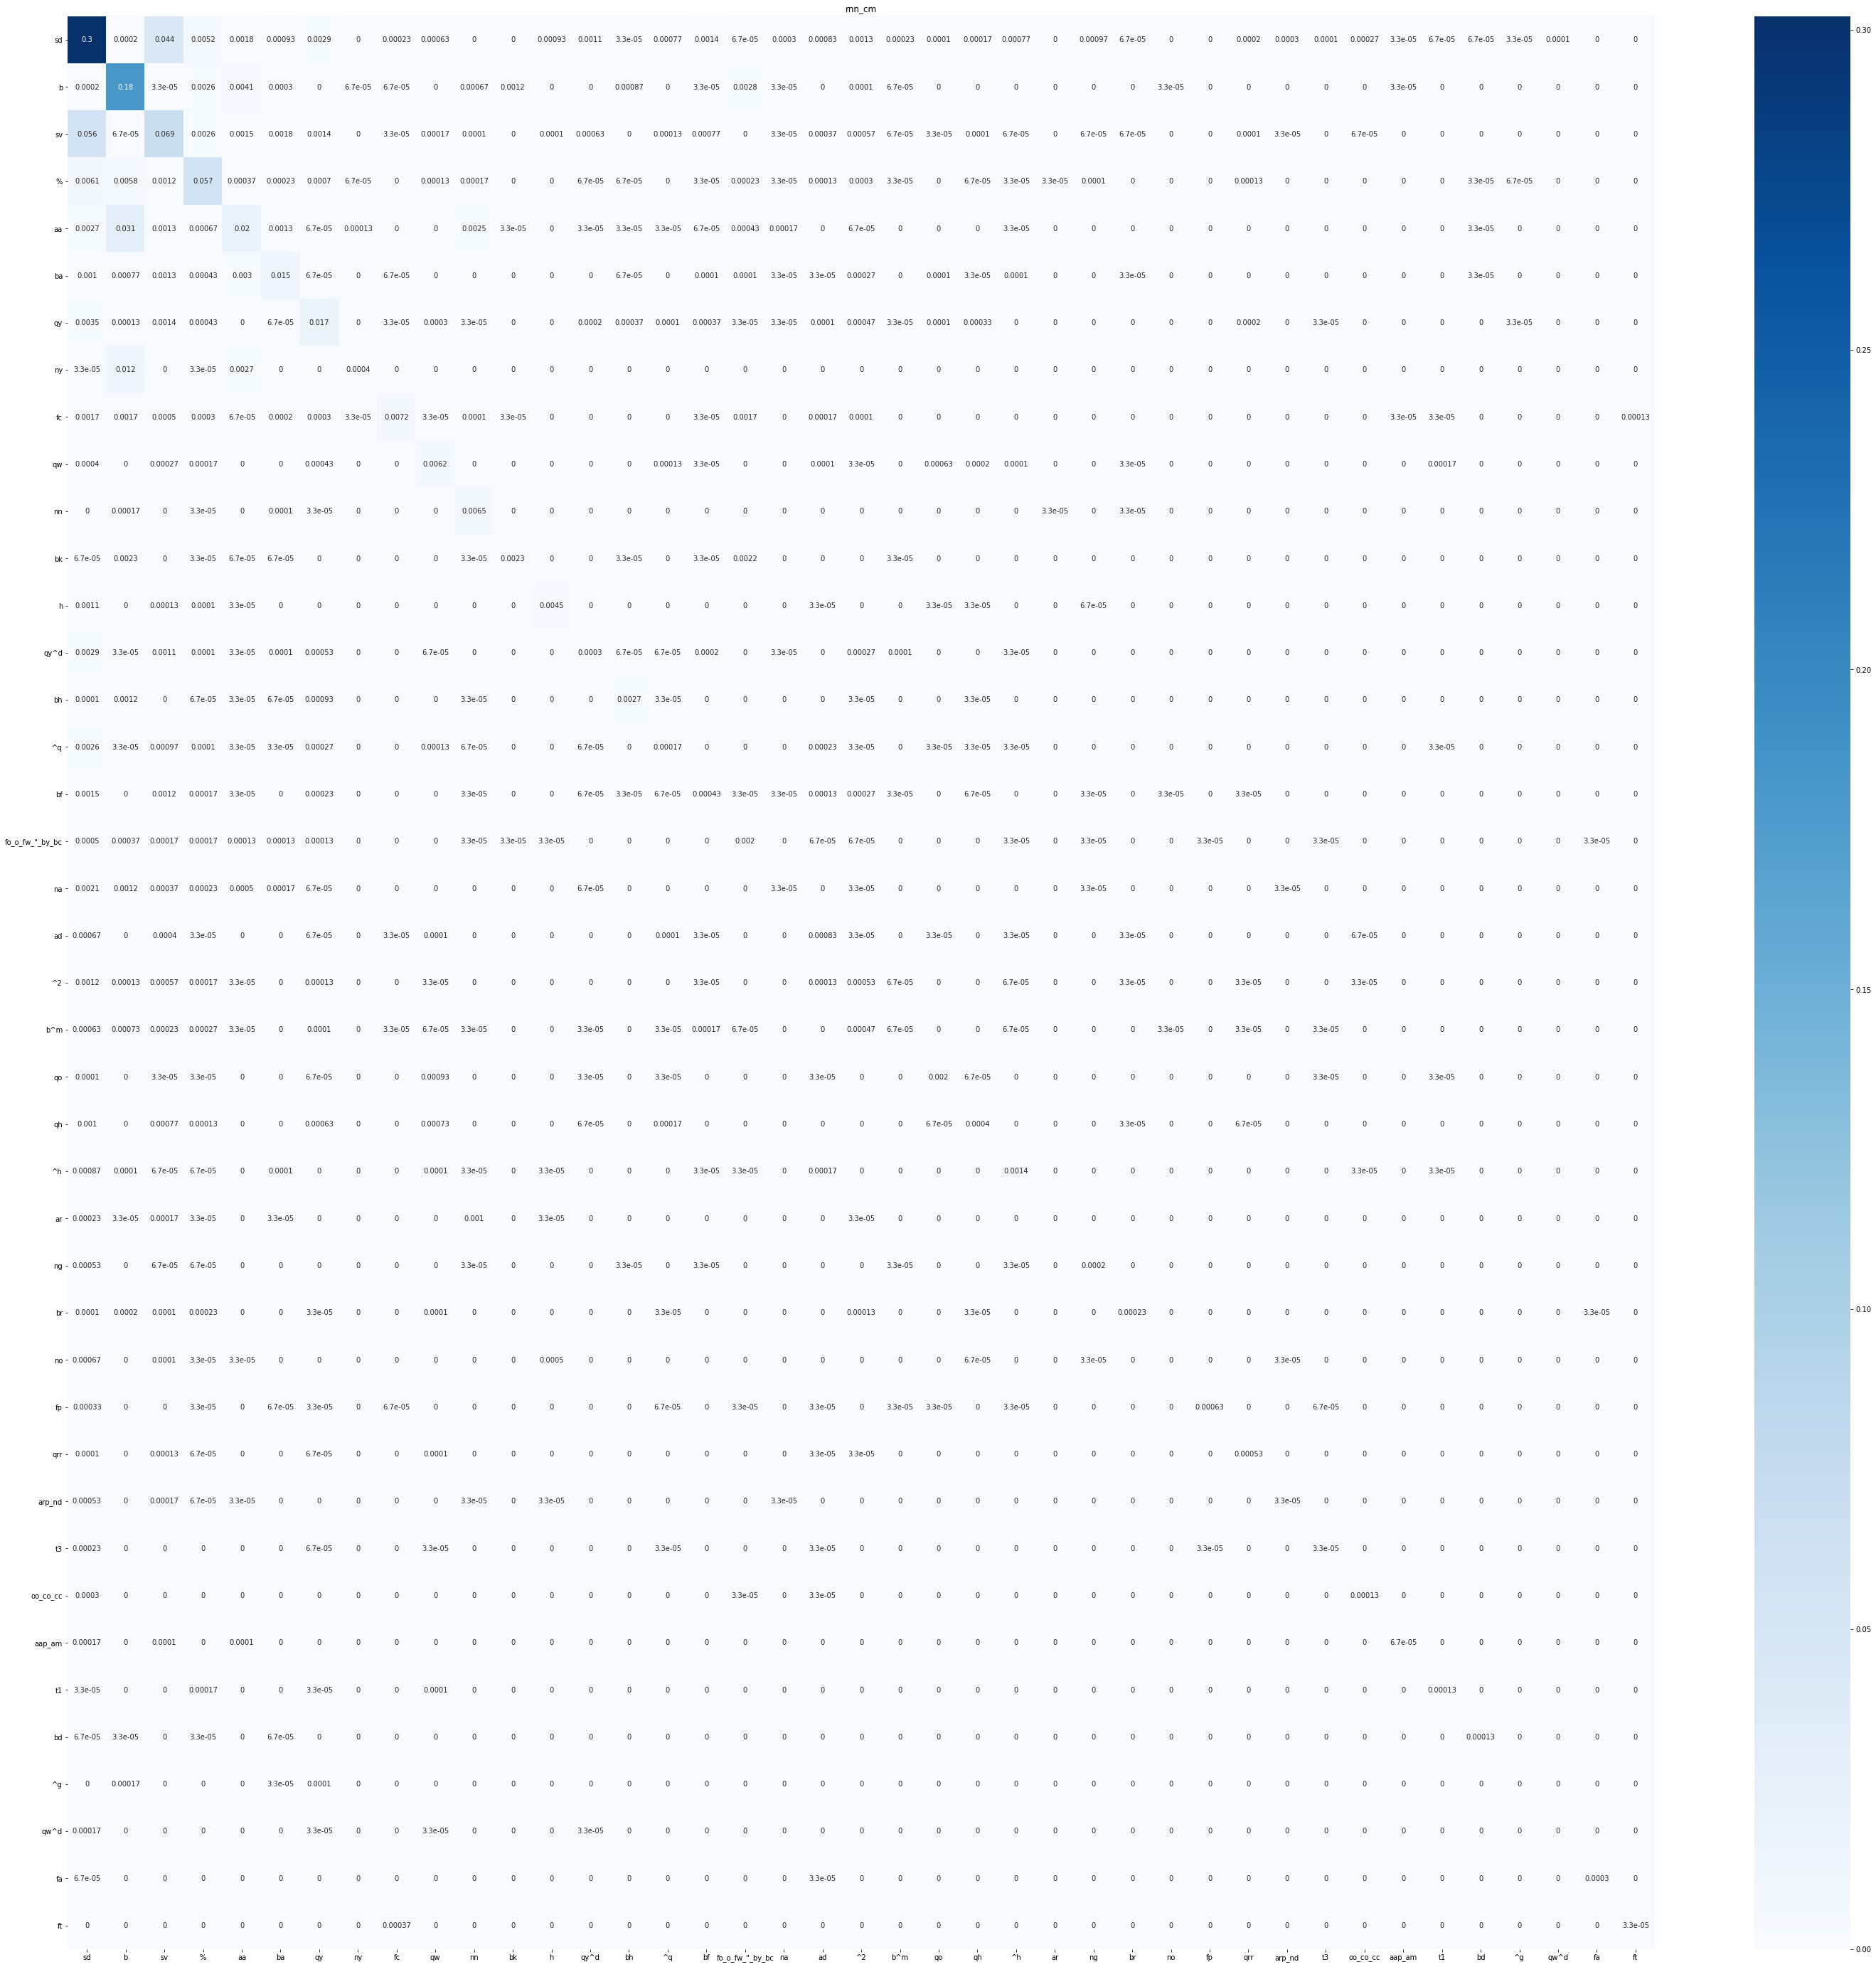

In [188]:
rnn_cm = confusion_matrix(y_test, y_pred, labels, normalize='all')
df = pd.DataFrame(rnn_cm, index=labels, columns=labels)
plt.figure(figsize=(50, 50))
plt.title("rnn_cm")
plt.ylabel("label")
plt.xlabel("label")
sns.heatmap(df, annot=True, cmap='Blues')
#plt.show()
plt.savefig("drive/My Drive/研究/swda_data/rnn_cm2.png")

### 評価関数

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
import pprint

In [189]:
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

              %       0.80      0.78      0.79      2206
             ^2       0.10      0.17      0.13        96
             ^g       0.00      0.00      0.00         9
             ^h       0.49      0.45      0.47        91
             ^q       0.08      0.03      0.05       146
             aa       0.58      0.33      0.42      1812
         aap_am       0.40      0.15      0.22        13
             ad       0.24      0.34      0.28        74
             ar       0.00      0.00      0.00        48
         arp_nd       0.08      0.04      0.05        28
              b       0.76      0.93      0.84      5855
            b^m       0.08      0.02      0.03        94
             ba       0.72      0.67      0.69       683
             bd       0.44      0.40      0.42        10
             bf       0.12      0.10      0.10       135
             bh       0.63      0.52      0.57       157
             bk       0.63    

## 可視化

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

## TensorBoard 可視化

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

### acc

In [ ]:
plot_graphs(history, 'accuracy')

### loss

In [ ]:
plot_graphs(history, 'loss')

## モデル(LSTM)

In [ ]:
BATCH_SIZE = 64

In [ ]:
X = tf.keras.Input(shape=(None,), batch_size=BATCH_SIZE)
embedded = tf.keras.layers.Embedding(encoder.vocab_size, 128)(X)
lstm = tf.keras.layers.LSTM(128, dropout=0.4, recurrent_dropout=0.4)(embedded)
fully_connected = tf.keras.layers.Dense(units=256, activation='relu')(lstm)
Y = tf.keras.layers.Dense(41, activation='sigmoid',name='final_layer')(fully_connected)
Rnn_Model = tf.keras.Model(inputs=X, outputs=Y)

Rnn_Model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])

In [ ]:
Rnn_Model.summary()

In [ ]:
history = Rnn_Model.fit(utter_train_data, epochs=5,
                    validation_data=utter_val_data, 
                    validation_steps=30)

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
plot_graphs(history, 'loss')

## モデル(双方向RNN)

In [ ]:
X = tf.keras.Input(shape=(None,), batch_size=BATCH_SIZE)
embedded = tf.keras.layers.Embedding(encoder.vocab_size, 128)(X)
lstm = tf.keras.layers.Bidirectional(
    tf.keras.layers.GRU(128, dropout=0.4, recurrent_dropout=0.4))(embedded)
fully_connected = tf.keras.layers.Dense(units=256, activation='relu')(lstm)
Y = tf.keras.layers.Dense(41, activation='sigmoid',
                          name='final_layer')(fully_connected)
Bidirectional_Rnn_Model = tf.keras.Model(inputs=X, outputs=Y)

Bidirectional_Rnn_Model.compile(loss='categorical_crossentropy',
                                optimizer=tf.keras.optimizers.Adam(1e-4),
                                metrics=generate_metrics())

In [ ]:
Bidirectional_Rnn_Model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(64, None)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (64, None, 128)           2847360   
_________________________________________________________________
bidirectional (Bidirectional (64, 256)                 198144    
_________________________________________________________________
dense_4 (Dense)              (64, 256)                 65792     
_________________________________________________________________
final_layer (Dense)          (64, 41)                  10537     
Total params: 3,121,833
Trainable params: 3,121,833
Non-trainable params: 0
_________________________________________________________________


In [ ]:
Bidirectional_RNN_history = Bidirectional_Rnn_Model.fit(utter_train_data, epochs=20,
                    validation_data=utter_val_data, 
                    validation_steps=30,
                   callbacks=[TensorBoard()])

Epoch 1/20
2601/2601 [==============================] - 804s 309ms/step - loss: 1.6644 - accuracy: 0.4203 - acc-0: 0.4599 - precision-0: 0.4343 - recall-0: 0.9742 - f_measure-0: 0.5755 - acc-1: 0.8254 - precision-1: 0.1322 - recall-1: 0.1781 - f_measure-1: 0.1452 - acc-2: 0.8619 - precision-2: 0.0668 - recall-2: 0.0590 - f_measure-2: 0.0534 - acc-3: 0.9218 - precision-3: 0.0953 - recall-3: 0.1039 - f_measure-3: 0.0909 - acc-4: 0.9437 - precision-4: 0.0081 - recall-4: 0.0028 - f_measure-4: 0.0037 - acc-5: 0.9750 - precision-5: 0.0488 - recall-5: 0.0426 - f_measure-5: 0.0408 - acc-6: 0.9757 - precision-6: 0.0237 - recall-6: 0.0150 - f_measure-6: 0.0165 - acc-7: 0.9845 - precision-7: 7.6894e-05 - recall-7: 9.6117e-05 - f_measure-7: 8.5437e-05 - acc-8: 0.9872 - precision-8: 0.0027 - recall-8: 5.1499e-04 - f_measure-8: 8.4262e-04 - acc-9: 0.9898 - precision-9: 0.0054 - recall-9: 0.0040 - f_measure-9: 0.0043 - acc-10: 0.9931 - precision-10: 0.0000e+00 - recall-10: 0.0000e+00 - f_measure-10: 

KeyboardInterrupt: ignored

### 可視化

In [ ]:
tensorboard --logdir ./logs

### モデルの保存

In [ ]:
Bidirectional_Rnn_Model.save("drive/My Drive/研究/swda_data/save_model/Bidirectional_gru_model.h5")

In [ ]:
x_test, y_test = next(iter(utter_test_data))
rnn_model.evaluate(x_test, y_test)

y_pred = np.argmax(rnn_model.predict(x_test), axis=1)
tf.math.confusion_matrix(np.argmax(y_test, axis=1), y_pred, num_classes=41)

## モデル(Attention + 順方向RNN)

In [ ]:
X = tf.keras.Input(shape=(None,), batch_size=BATCH_SIZE)
embedded = tf.keras.layers.Embedding(encoder.vocab_size, 64)(X)
lstm, forward_h, forward_c = tf.keras.layers.LSTM(128,
                                                return_sequences=True,
                                                return_state=True, 
                                                dropout=0.4, 
                                                recurrent_dropout=0.4)(embedded)
#state_h = tf.keras.layers.Concatenate()([forward_h, backward_h]) # 重みを結合
context,attention_weights = Attention(64)(lstm,forward_h) # ここにAttentionレイヤを挟む
fully_connected = tf.keras.layers.Dense(units=128, activation='relu')(context)
Y = tf.keras.layers.Dense(41, activation='sigmoid',name='final_layer')(fully_connected)

Attention_Model = tf.keras.Model(inputs=X, outputs=Y)

Attention_Model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['acc'])

NameError: ignored

In [ ]:
Attention_Model.summary()

In [ ]:
Att_history = Attention_Model.fit(utter_train_data, epochs=5,
                    validation_data=utter_val_data, 
                    validation_steps=30,
                   callbacks=[tensorboard_callback])

In [ ]:
plot_graphs(Att_history, 'acc')

In [ ]:
plot_graphs(Att_history, 'loss')

## モデル(Attention + 双方向RNN)

In [ ]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
X = tf.keras.Input(shape=(None,), batch_size=BATCH_SIZE)
embedded = tf.keras.layers.Embedding(encoder.vocab_size, 64)(X)
lstm, forward_h, forward_c, backward_h, backward_c = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True,return_state=True, dropout=0.4, recurrent_dropout=0.4))(embedded)
state_h = tf.keras.layers.Concatenate()([forward_h, backward_h]) # 重みを結合
context,attention_weights = Attention(64)(lstm,state_h) # ここにAttentionレイヤを挟む
fully_connected = tf.keras.layers.Dense(units=128, activation='relu')(context)
Y = tf.keras.layers.Dense(41, activation='sigmoid',name='final_layer')(fully_connected)

Bidirectional_Attention_Model = tf.keras.Model(inputs=X, outputs=Y)

Bidirectional_Attention_Model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['acc'])

NameError: ignored

In [ ]:
Bidirectional_Attention_Model.summary()

In [ ]:
Bidirectional_Att_history = Bidirectional_Attention_Model.fit(utter_train_data, epochs=5,
                    validation_data=utter_val_data, 
                    validation_steps=30,
                   callbacks=[tensorboard_callback])

In [ ]:
plot_graphs(Bidirectional_Att_history, 'acc')

In [ ]:
plot_graphs(Bidirectional_Att_history, 'loss')

## Accuracy Precision Recall F-measure

In [40]:
import tensorflow.keras.backend as K
from functools import partial

## y_predの正規化
def normalize_y_pred(y_pred):
    return K.one_hot(K.argmax(y_pred), y_pred.shape[-1])

## クラスごと(True Positive)
def class_true_positive(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label] + y_pred[:, class_label], 2),
                  K.floatx())
    
## 全体(True Positive)
def true_positive(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true + y_pred, 2),
                  K.floatx())
    
## クラスごと(Precision)
def class_precision(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(class_true_positive(class_label, y_true, y_pred)) / (K.sum(y_pred[:, class_label]) + K.epsilon())

## micro(Precision)
def micro_precision(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(true_positive(y_true, y_pred)) / (K.sum(y_pred) + K.epsilon())

## macro(Precision)
def macro_precision(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_precision(i, y_true, y_pred) for i in range(class_count)]) \
           / K.cast(class_count, K.floatx())

## クラスごと(Recall)
def class_recall(class_label, y_true, y_pred):
    return K.sum(class_true_positive(class_label, y_true, y_pred)) / (K.sum(y_true[:, class_label]) + K.epsilon())

## micro(Recall)
def micro_recall(y_true, y_pred):
    return K.sum(true_positive(y_true, y_pred)) / (K.sum(y_true) + K.epsilon())

## macro(Recall)
def macro_recall(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_recall(i, y_true, y_pred) for i in range(class_count)]) \
           / K.cast(class_count, K.floatx())

## クラスごと(F-measure)
def class_f_measure(class_label, y_true, y_pred):
    precision = class_precision(class_label, y_true, y_pred)
    recall = class_recall(class_label, y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())

## micro(F-measure)
def micro_f_measure(y_true, y_pred):
    precision = micro_precision(y_true, y_pred)
    recall = micro_recall(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())

## macro(F-measure)
def macro_f_measure(y_true, y_pred):
    precision = macro_precision(y_true, y_pred)
    recall = macro_recall(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())

## クラスごと(Accuracy)
def class_accuracy(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label], y_pred[:, class_label]),
                  K.floatx())
    
## Average(Accuracy)
def average_accuracy(y_true, y_pred):
    class_count = y_pred.shape[-1]
    class_acc_list = [class_accuracy(i, y_true, y_pred) for i in range(class_count)]
    class_acc_matrix = K.concatenate(class_acc_list, axis=0)
    return K.mean(class_acc_matrix, axis=0)

## metric
def generate_metrics():
    metrics = ["accuracy"]

    # classごとのmetrics
    func_list = [class_accuracy, class_precision, class_recall, class_f_measure]
    name_list = ["acc", "precision", "recall", "f_measure"]
    for i in range(41):
        for func, name in zip(func_list, name_list):
            func = partial(func, i)
            func.__name__ = "{}-{}".format(name, i)
            metrics.append(func)

    # 全体のmetrics
    metrics.append(average_accuracy)
    metrics.append(macro_precision)
    metrics.append(macro_recall)
    metrics.append(macro_f_measure)
    metrics.append(micro_precision)
    metrics.append(micro_recall)
    metrics.append(micro_f_measure)

    return metrics

## self-Attentionの分類モデル

In [41]:
from tensorflow.keras.callbacks import TensorBoard

In [42]:
pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.47.0-cp36-none-any.whl size=17289 sha256=2447b1b70489bd6132e856ed367519cd57012b97d11fb5176fab8ee6d494887b
  Stored in directory: /root/.cache/pip/wheels/70/87/01/76c703d5401b65e323927c1fdc665f3fb143282ff67d71e859
Successfully built keras-self-attention


In [44]:
from keras_self_attention import SeqSelfAttention

### モデル設定

In [43]:
BATCH_SIZE = 64

#### attentionから先のモデル

In [ ]:
inp = tf.keras.Input(shape=(None,), batch_size=BATCH_SIZE)
emb_output = tf.keras.layers.Embedding(22302, 64)(inp) # (?,128,32)
att_layer_output = SeqSelfAttention(name='attention')(emb_output)  # embbedingレイヤーの後にselfattentionを配置
gru_output = tf.keras.layers.GRU(64)(att_layer_output)
output = tf.keras.layers.Dense(41, activation='softmax')(gru_output)  # shape=(?, 41)
self_attention_modelv1 = tf.keras.Model(inp, output)
self_attention_modelv1.summary()
self_attention_modelv1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=generate_metrics())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, None)]              0         
_________________________________________________________________
embedding (Embedding)        (64, None, 64)            1427328   
_________________________________________________________________
attention (SeqSelfAttention) (64, None, 64)            4161      
_________________________________________________________________
gru (GRU)                    (64, 64)                  24960     
_________________________________________________________________
dense (Dense)                (64, 41)                  2665      
Total params: 1,459,114
Trainable params: 1,459,114
Non-trainable params: 0
_________________________________________________________________


#### attentionがあとのAvgpooling

In [ ]:
inp = tf.keras.Input(shape=(None,), batch_size=BATCH_SIZE)
emb_output = tf.keras.layers.Embedding(22302, 64)(inp) # (?,128,32)
gru_output = tf.keras.layers.GRU(64,return_sequences=True)(emb_output)
att_layer_output = SeqSelfAttention(name='attention')(gru_output)  # embbedingレイヤーの後にselfattentionを配置
out = tf.keras.layers.GlobalAveragePooling1D()(att_layer_output) # outputのshapeの次元数を落とす(3次元->2次元)
output = tf.keras.layers.Dense(41, activation='softmax')(out)  # shape=(?, 41)
self_attention_model_avg = tf.keras.Model(inp, output)
self_attention_model_avg.summary()
self_attention_model_avg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=generate_metrics())

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(64, None)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (64, None, 64)            1427328   
_________________________________________________________________
gru_1 (GRU)                  (64, None, 64)            24960     
_________________________________________________________________
attention (SeqSelfAttention) (64, None, 64)            4161      
_________________________________________________________________
global_average_pooling1d (Gl (64, 64)                  0         
_________________________________________________________________
dense_1 (Dense)              (64, 41)                  2665      
Total params: 1,459,114
Trainable params: 1,459,114
Non-trainable params: 0
____________________________________________

#### attentionがあとのmaxpooling

In [45]:
inp = tf.keras.Input(shape=(None,), batch_size=BATCH_SIZE)
emb_output = tf.keras.layers.Embedding(22302, 64)(inp) # (?,128,32)
gru_output = tf.keras.layers.GRU(64,return_sequences=True)(emb_output)
att_layer_output = SeqSelfAttention(name='attention')(gru_output)  # embbedingレイヤーの後にselfattentionを配置
out = tf.keras.layers.GlobalMaxPooling1D()(att_layer_output) # outputのshapeの次元数を落とす(3次元->2次元)
output = tf.keras.layers.Dense(41, activation='softmax')(out)  # shape=(?, 41)
self_attention_model_max = tf.keras.Model(inp, output)
self_attention_model_max.summary()
self_attention_model_max.compile(optimizer='adam', loss='categorical_crossentropy', metrics=generate_metrics())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, None)]              0         
_________________________________________________________________
embedding (Embedding)        (64, None, 64)            1427328   
_________________________________________________________________
gru (GRU)                    (64, None, 64)            24960     
_________________________________________________________________
attention (SeqSelfAttention) (64, None, 64)            4161      
_________________________________________________________________
global_max_pooling1d (Global (64, 64)                  0         
_________________________________________________________________
dense (Dense)                (64, 41)                  2665      
Total params: 1,459,114
Trainable params: 1,459,114
Non-trainable params: 0
____________________________________________

#### self-attention only

In [ ]:
inp = tf.keras.Input(shape=(None,), batch_size=BATCH_SIZE)
emb_output = tf.keras.layers.Embedding(22302, 64)(inp) # (?,128,32)
att_layer_output = SeqSelfAttention(name='attention')(emb_output)  # embbedingレイヤーの後にselfattentionを配置
out = tf.keras.layers.GlobalMaxPooling1D()(att_layer_output) # outputのshapeの次元数を落とす(3次元->2次元)
output = tf.keras.layers.Dense(41, activation='softmax')(out)  # shape=(?, 41)
self_attention_only_model = tf.keras.Model(inp, output)
self_attention_only_model.summary()
self_attention_only_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=generate_metrics())

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(64, None)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (64, None, 64)            1427328   
_________________________________________________________________
attention (SeqSelfAttention) (64, None, 64)            4161      
_________________________________________________________________
global_max_pooling1d_1 (Glob (64, 64)                  0         
_________________________________________________________________
dense_3 (Dense)              (64, 41)                  2665      
Total params: 1,434,154
Trainable params: 1,434,154
Non-trainable params: 0
_________________________________________________________________


### モデル学習

#### AvgPoolingの学習

In [ ]:
self_attention_history_v2 = self_attention_model_avg.fit(utter_train_data, epochs=14,
                    validation_data=utter_val_data,
                    validation_steps=30,
                    callbacks=[TensorBoard()])

Epoch 1/14
   1/2913 [..............................] - ETA: 39s - loss: 3.7075 - accuracy: 0.0000e+00 - acc-0: 0.6562 - precision-0: 0.0000e+00 - recall-0: 0.0000e+00 - f_measure-0: 0.0000e+00 - acc-1: 0.8438 - precision-1: 0.0000e+00 - recall-1: 0.0000e+00 - f_measure-1: 0.0000e+00 - acc-2: 0.8750 - precision-2: 0.0000e+00 - recall-2: 0.0000e+00 - f_measure-2: 0.0000e+00 - acc-3: 0.9219 - precision-3: 0.0000e+00 - recall-3: 0.0000e+00 - f_measure-3: 0.0000e+00 - acc-4: 0.9688 - precision-4: 0.0000e+00 - recall-4: 0.0000e+00 - f_measure-4: 0.0000e+00 - acc-5: 0.9688 - precision-5: 0.0000e+00 - recall-5: 0.0000e+00 - f_measure-5: 0.0000e+00 - acc-6: 0.9062 - precision-6: 0.0000e+00 - recall-6: 0.0000e+00 - f_measure-6: 0.0000e+00 - acc-7: 0.9375 - precision-7: 0.0000e+00 - recall-7: 0.0000e+00 - f_measure-7: 0.0000e+00 - acc-8: 1.0000 - precision-8: 0.0000e+00 - recall-8: 0.0000e+00 - f_measure-8: 0.0000e+00 - acc-9: 0.9844 - precision-9: 0.0000e+00 - recall-9: 0.0000e+00 - f_measure-9

#### 前回のself-attentionmモデルの学習

In [ ]:
self_attention_history_v1 = self_attention_modelv1.fit(utter_train_data, epochs=14,
                    validation_data=utter_val_data,
                    validation_steps=30,
                    callbacks=[TensorBoard()])

Epoch 1/14
2913/2913 [==============================] - 219s 75ms/step - loss: 1.1828 - accuracy: 0.6551 - acc-0: 0.7933 - precision-0: 0.6760 - recall-0: 0.8973 - f_measure-0: 0.7498 - acc-1: 0.9119 - precision-1: 0.6856 - recall-1: 0.9146 - f_measure-1: 0.7696 - acc-2: 0.8723 - precision-2: 0.3842 - recall-2: 0.3265 - f_measure-2: 0.3128 - acc-3: 0.9473 - precision-3: 0.6125 - recall-3: 0.5383 - f_measure-3: 0.5394 - acc-4: 0.9456 - precision-4: 0.2947 - recall-4: 0.1679 - f_measure-4: 0.1916 - acc-5: 0.9815 - precision-5: 0.3335 - recall-5: 0.3285 - f_measure-5: 0.3122 - acc-6: 0.9772 - precision-6: 0.3052 - recall-6: 0.2870 - f_measure-6: 0.2772 - acc-7: 0.9845 - precision-7: 0.0206 - recall-7: 0.0136 - f_measure-7: 0.0148 - acc-8: 0.9898 - precision-8: 0.0850 - recall-8: 0.0515 - f_measure-8: 0.0606 - acc-9: 0.9896 - precision-9: 0.2081 - recall-9: 0.2309 - f_measure-9: 0.2108 - acc-10: 0.9933 - precision-10: 0.1772 - recall-10: 0.1927 - f_measure-10: 0.1792 - acc-11: 0.9927 - pre

#### MaxPoolingの学習

In [82]:
self_attention_history_v3 = self_attention_model_max.fit(utter_train_data, epochs=14,
                    validation_data=utter_val_data,
                    validation_steps=30,
                    callbacks=[TensorBoard()])

Epoch 1/14
   1/2601 [..............................] - ETA: 3s - loss: 3.7309 - accuracy: 0.0000e+00 - acc-0: 0.5000 - precision-0: 0.0000e+00 - recall-0: 0.0000e+00 - f_measure-0: 0.0000e+00 - acc-1: 0.6406 - precision-1: 0.0000e+00 - recall-1: 0.0000e+00 - f_measure-1: 0.0000e+00 - acc-2: 0.9844 - precision-2: 0.0000e+00 - recall-2: 0.0000e+00 - f_measure-2: 0.0000e+00 - acc-3: 0.9375 - precision-3: 0.0000e+00 - recall-3: 0.0000e+00 - f_measure-3: 0.0000e+00 - acc-4: 1.0000 - precision-4: 0.0000e+00 - recall-4: 0.0000e+00 - f_measure-4: 0.0000e+00 - acc-5: 0.9531 - precision-5: 0.0000e+00 - recall-5: 0.0000e+00 - f_measure-5: 0.0000e+00 - acc-6: 0.9844 - precision-6: 0.0000e+00 - recall-6: 0.0000e+00 - f_measure-6: 0.0000e+00 - acc-7: 0.0156 - precision-7: 0.0000e+00 - recall-7: 0.0000e+00 - f_measure-7: 0.0000e+00 - acc-8: 1.0000 - precision-8: 0.0000e+00 - recall-8: 0.0000e+00 - f_measure-8: 0.0000e+00 - acc-9: 1.0000 - precision-9: 0.0000e+00 - recall-9: 0.0000e+00 - f_measure-9:

KeyboardInterrupt: ignored

#### self-attentionだけの学習

In [ ]:
self_attention_only_history = self_attention_only_model.fit(utter_train_data, epochs=14,
                    validation_data=utter_val_data,
                    validation_steps=30,
                    callbacks=[TensorBoard()])

Epoch 1/14
2913/2913 [==============================] - 212s 73ms/step - loss: 1.4955 - accuracy: 0.5780 - acc-0: 0.6967 - precision-0: 0.5715 - recall-0: 0.9538 - f_measure-0: 0.6934 - acc-1: 0.8910 - precision-1: 0.5891 - recall-1: 0.8402 - f_measure-1: 0.6791 - acc-2: 0.8644 - precision-2: 0.1498 - recall-2: 0.0589 - f_measure-2: 0.0716 - acc-3: 0.9326 - precision-3: 0.4497 - recall-3: 0.2264 - f_measure-3: 0.2783 - acc-4: 0.9448 - precision-4: 0.1798 - recall-4: 0.0826 - f_measure-4: 0.1010 - acc-5: 0.9785 - precision-5: 0.2308 - recall-5: 0.2007 - f_measure-5: 0.2004 - acc-6: 0.9706 - precision-6: 0.1589 - recall-6: 0.1523 - f_measure-6: 0.1412 - acc-7: 0.9847 - precision-7: 0.0058 - recall-7: 0.0027 - f_measure-7: 0.0034 - acc-8: 0.9892 - precision-8: 0.0737 - recall-8: 0.0280 - f_measure-8: 0.0386 - acc-9: 0.9889 - precision-9: 0.1260 - recall-9: 0.1199 - f_measure-9: 0.1170 - acc-10: 0.9928 - precision-10: 0.1722 - recall-10: 0.1927 - f_measure-10: 0.1767 - acc-11: 0.9930 - pre

### モデルの保存

### Tensorboardでの可視化

### 混合行列 評価

*   GRU + Self-Attention + Avg-Poolingモデルの評価
*   GRU + Self-Attention + Max-Poolingモデルの評価
*   Self-Attention + GRUモデルの評価
*   Self-Attention onlyモデルの評価



In [146]:
import seaborn as sns
import matplotlib.pyplot as plt

In [147]:
from sklearn.metrics import classification_report
import pandas as pd
import pprint
from sklearn.metrics import confusion_matrix

### self-attention avgpooling使用

In [ ]:
y_test = []
y_pred = []
for x, y in utter_test_data:
    pred = np.argmax(self_attention_model_avg.predict(x), axis=1)
    for i in np.argmax(y, axis=1):
      y_test.append(labels[i])

    for i in pred:
      y_pred.append(labels[i])

print(len(y_test))

9984


In [ ]:
print(classification_report(y_test, y_pred,
                            target_names=labels))

                 precision    recall  f1-score   support

             sd       0.79      0.76      0.78       695
              b       0.05      0.05      0.05        42
             sv       0.00      0.00      0.00         3
              %       0.68      0.61      0.64        28
             aa       0.08      0.04      0.05        49
             ba       0.57      0.34      0.43       604
             qy       0.00      0.00      0.00         5
             ny       0.20      0.32      0.24        19
             fc       0.38      0.23      0.29        13
             qw       0.00      0.00      0.00        11
             nn       0.74      0.95      0.83      1953
             bk       0.07      0.06      0.06        17
              h       0.74      0.63      0.68       244
           qy^d       0.00      0.00      0.00         1
             bh       0.08      0.07      0.07        46
             ^q       0.68      0.30      0.42        63
             bf       0.69    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
atten_avg_cm = confusion_matrix(y_test, y_pred, labels)
df = pd.DataFrame(atten_avg_cm, index=labels, columns=labels)
df

,sd,b,sv,%,aa,ba,qy,ny,fc,qw,nn,bk,h,qy^d,bh,^q,bf,"fo_o_fw_""_by_bc",na,ad,^2,b^m,qo,qh,^h,ar,ng,br,no,fp,qrr,arp_nd,t3,oo_co_cc,aap_am,t1,bd,^g,qw^d,fa,ft
sd,2958,4,479,39,13,8,22,0,3,4,0,0,8,8,0,9,14,1,7,14,12,4,0,1,1,1,6,1,3,0,1,1,0,0,1,0,0,0,0,1,0
b,3,1847,2,28,47,3,0,2,0,0,6,6,0,0,5,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
sv,535,0,769,22,13,13,21,0,0,1,1,0,0,3,1,5,9,0,1,5,7,1,0,1,2,1,2,1,0,0,0,0,0,0,1,0,0,0,1,0,0
%,56,54,26,530,2,1,8,0,0,0,2,0,0,0,0,0,1,0,2,0,4,1,0,2,0,0,1,2,0,0,2,0,0,0,1,0,0,0,0,0,0
aa,20,303,22,8,206,8,1,3,1,0,24,1,0,0,0,0,2,0,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ba,9,10,15,1,47,154,1,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
qy,34,1,17,6,0,1,164,0,0,3,0,0,0,4,0,0,3,0,0,1,2,1,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
ny,0,124,0,1,24,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
fc,7,22,5,2,2,2,1,0,66,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
qw,4,0,2,2,0,0,1,0,0,65,0,0,0,0,1,1,0,0,0,0,1,0,5,3,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0


### self-attention maxpooling使用

---



In [148]:
y_test = []
y_pred = []
for x, y in utter_test_data:
    pred = np.argmax(self_attention_model_max.predict(x), axis=1)
    for i in np.argmax(y, axis=1):
      y_test.append(labels[i])
    for i in pred:
      y_pred.append(labels[i])

print(len(y_test))

29952


In [174]:
y_test = []
y_pred = []
for x, y in utter_test_data:
    pred = np.argmax(self_attention_model_max.predict(x), axis=1)
    for i in np.argmax(y, axis=1):
      y_test.append(labels[i])
    for i in pred:
      y_pred.append(labels[i])


In [165]:
pip install pycm

     |████████████████████████████████| 71kB 3.0MB/s 
     |████████████████████████████████| 563kB 12.3MB/s 


In [166]:
from pycm import ConfusionMatrix
cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred)
cm.print_normalized_matrix()

Predict               %                     ^2                    ^g                    ^h                    ^q                    aa                    aap_am                ad                    ar                    arp_nd                b                     b^m                   ba                    bd                    bf                    bh                    bk                    br                    fa                    fc                    fo_o_fw_"_by_bc       fp                    ft                    h                     na                    ng                    nn                    no                    ny                    oo_co_cc              qh                    qo                    qrr                   qw                    qw^d                  qy                    qy^d                  sd                    sv                    t1                    t3                    
Actual
%                     0.76337               0.00544               0.

/usr/local/lib/python3.6/dist-packages/pycm/pycm_obj.py:148: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
If confusion matrix has too many zeros (sparse matrix) you can set `sparse` flag to True in printing functions otherwise by using save_csv method to save the confusion matrix in csv format you'll have better demonstration.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)


In [152]:
x_tests=[] 
y_tests=[]
for x,y in utter_test_data:
  x_tests.append(x)
  y_tests.append(y)

In [177]:
print(classification_report(y_test, y_pred))
                            #target_names=labels))

                 precision    recall  f1-score   support

              %       0.83      0.76      0.80      2206
             ^2       0.08      0.12      0.10        96
             ^g       0.00      0.00      0.00         9
             ^h       0.55      0.44      0.49        91
             ^q       0.14      0.04      0.06       146
             aa       0.61      0.31      0.41      1812
         aap_am       0.11      0.15      0.12        13
             ad       0.27      0.42      0.33        74
             ar       0.33      0.02      0.04        48
         arp_nd       0.00      0.00      0.00        28
              b       0.74      0.95      0.83      5855
            b^m       0.15      0.07      0.10        94
             ba       0.72      0.70      0.71       683
             bd       0.67      0.40      0.50        10
             bf       0.09      0.05      0.07       135
             bh       0.63      0.52      0.57       157
             bk       0.69    

In [160]:
from sklearn.metrics import plot_confusion_matrix
from sklearn import preprocessing


In [ ]:
mm = preprocessing.MinMaxScaler()
l_2d_min_max = mm.fit_transform

In [163]:
plot_confusion_matrix(y_test, y_pred,labels,normalize=True)

ValueError: ignored

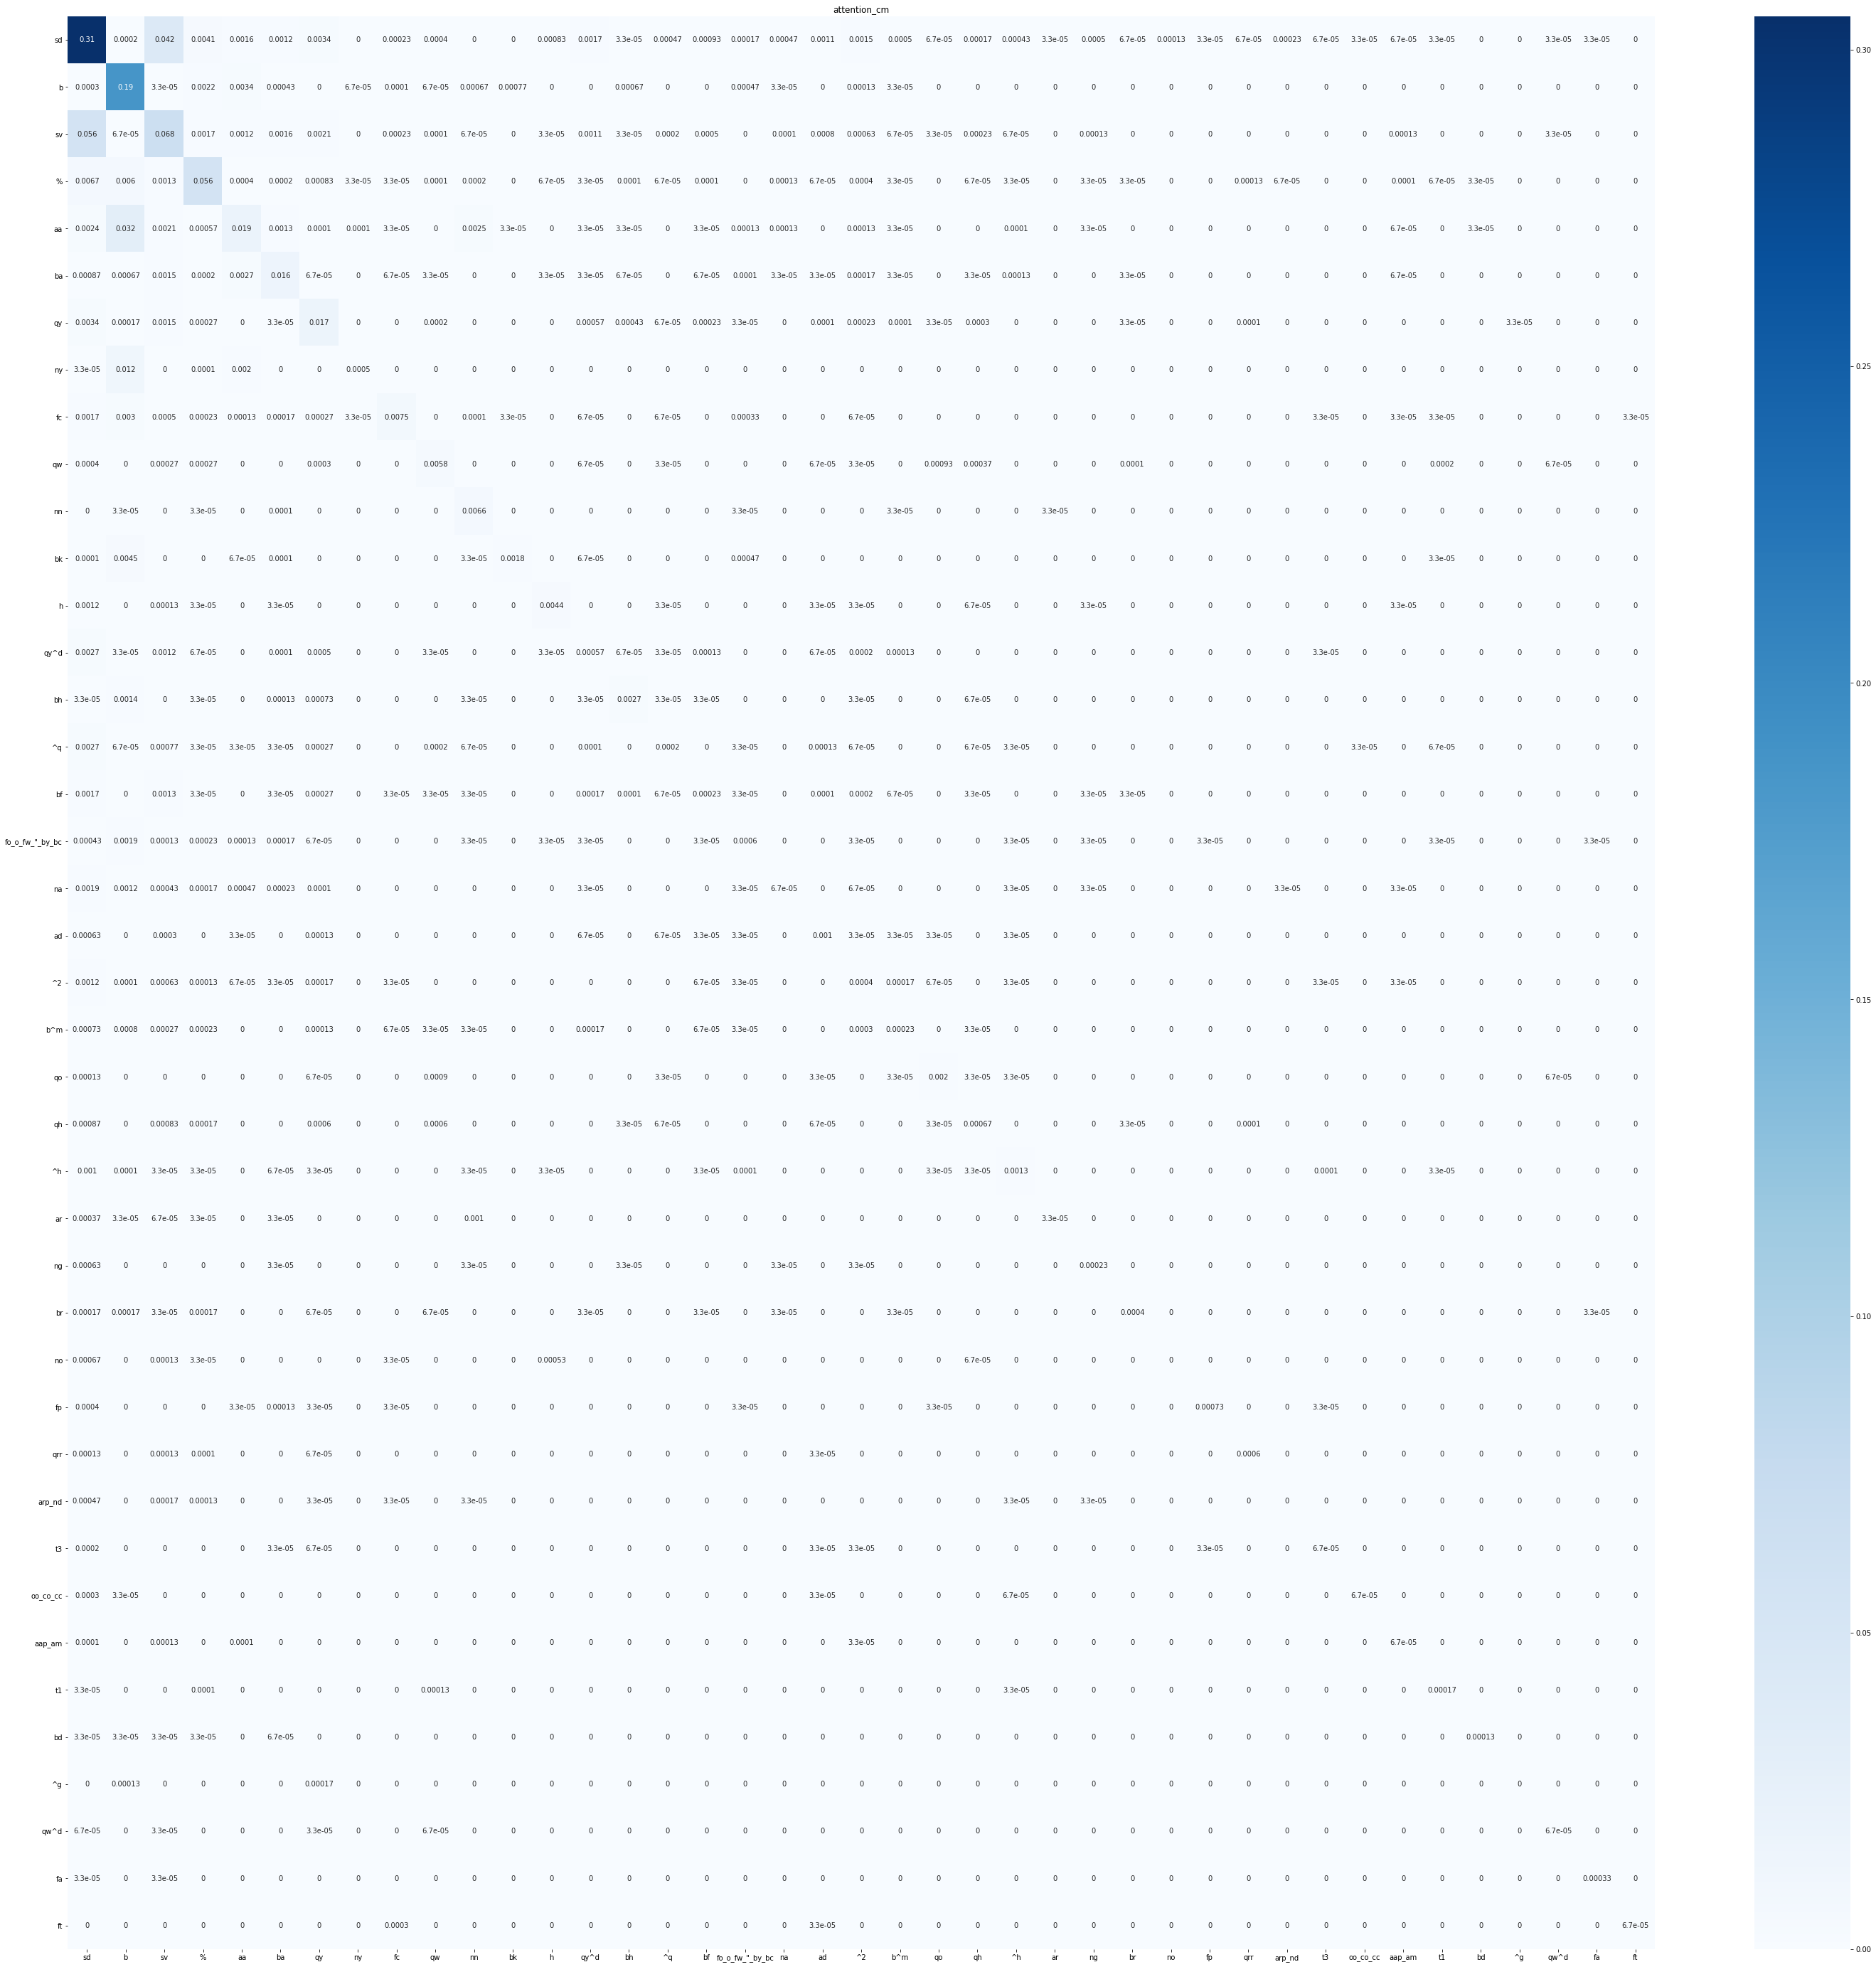

In [185]:
attention_cm = confusion_matrix(y_test, y_pred, labels, normalize='all')
df = pd.DataFrame(attention_cm, index=labels, columns=labels)
plt.figure(figsize=(50, 50))
plt.title("attention_cm")
plt.ylabel("label")
plt.xlabel("label")
sns.heatmap(df, annot=True, cmap='Blues')
#plt.show()
plt.savefig("drive/My Drive/研究/swda_data/attention_cm2.png")

#### テストデータのラベルの棒グラフ

In [ ]:
y_labels=[0]*41
for i,v in enumerate(labels):
  count = 0
  for j in y_test:
    if v == j:
      count += 1
  y_labels[i] = count

In [ ]:
import matplotlib.pyplot as plt

x_labels = [x for x in range(0,41)]
y_labels

plt.figure(figsize=(50, 25))
plt.bar(labels, y_labels)
plt.title("Number of labels for each class of test data")
plt.xlabel("label")
plt.ylabel("Number of labels")
plt.savefig("drive/My Drive/研究/swda_data/テストデータのラベル数.png")

#### 訓練データのラベルの棒グラフ

In [ ]:
x_lists = []
for _, v in utter_train_data:
    for x in np.argmax(v, axis=1):
      x_lists.append(labels[x])

In [ ]:
print(len(x_lists))

### 前回のself-attentionの評価

In [ ]:
y_test = []
y_pred = []
for x, y in utter_test_data:
    pred = np.argmax(self_attention_modelv1.predict(x), axis=1)
    for i in np.argmax(y, axis=1):
      y_test.append(labels[i])

    for i in pred:
      y_pred.append(labels[i])

print(len(y_test))

9984


In [ ]:
print(classification_report(y_test, y_pred,
                            target_names=labels))

                 precision    recall  f1-score   support

             sd       0.80      0.76      0.78       695
              b       0.16      0.12      0.14        42
             sv       0.00      0.00      0.00         3
              %       0.62      0.57      0.59        28
             aa       0.00      0.00      0.00        49
             ba       0.54      0.34      0.42       604
             qy       0.00      0.00      0.00         5
             ny       0.28      0.37      0.32        19
             fc       0.00      0.00      0.00        13
             qw       0.00      0.00      0.00        11
             nn       0.75      0.94      0.83      1953
             bk       0.08      0.06      0.07        17
              h       0.77      0.61      0.68       244
           qy^d       0.00      0.00      0.00         1
             bh       0.08      0.04      0.06        46
             ^q       0.74      0.41      0.53        63
             bf       0.65    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
atten_cm = confusion_matrix(y_test, y_pred, labels)
df = pd.DataFrame(atten_cm, index=labels, columns=labels)
df

,sd,b,sv,%,aa,ba,qy,ny,fc,qw,nn,bk,h,qy^d,bh,^q,bf,"fo_o_fw_""_by_bc",na,ad,^2,b^m,qo,qh,^h,ar,ng,br,no,fp,qrr,arp_nd,t3,oo_co_cc,aap_am,t1,bd,^g,qw^d,fa,ft
sd,3102,4,328,43,18,3,28,0,1,6,4,1,6,15,0,8,11,4,5,4,5,6,1,6,5,0,3,1,0,0,1,2,1,0,1,1,0,0,0,0,0
b,4,1831,0,27,49,4,0,0,5,0,6,7,0,1,5,0,1,12,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
sv,648,1,661,18,16,16,17,0,0,0,1,0,0,5,1,1,3,0,0,8,7,0,0,1,1,0,1,1,1,0,3,1,1,0,1,0,0,0,2,0,0
%,68,53,15,531,4,0,9,0,1,1,3,0,1,0,0,0,0,0,1,0,6,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
aa,31,308,12,6,205,4,2,4,0,0,25,2,0,2,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ba,11,9,18,5,49,150,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
qy,55,1,22,10,0,2,137,0,0,1,0,0,0,2,1,0,1,0,0,1,1,1,2,0,0,1,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0
ny,0,127,0,1,26,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
fc,9,16,2,3,1,3,4,0,64,0,1,1,0,0,0,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
qw,10,0,3,3,0,0,5,0,0,54,0,0,0,0,0,2,0,0,0,0,0,0,2,8,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


### self-attention onlyモデル



In [ ]:
y_test = []
y_pred = []
for x, y in utter_test_data:
    pred = np.argmax(self_attention_only_model.predict(x), axis=1)
    for i in np.argmax(y, axis=1):
      y_test.append(labels[i])

    for i in pred:
      y_pred.append(labels[i])

print(len(y_test))

9984


In [ ]:
print(classification_report(y_test, y_pred,
                            target_names=labels))

                 precision    recall  f1-score   support

             sd       0.79      0.75      0.77       695
              b       0.29      0.10      0.14        42
             sv       0.00      0.00      0.00         3
              %       0.67      0.50      0.57        28
             aa       0.10      0.02      0.03        49
             ba       0.58      0.35      0.44       604
             qy       0.00      0.00      0.00         5
             ny       0.29      0.37      0.33        19
             fc       0.00      0.00      0.00        13
             qw       0.00      0.00      0.00        11
             nn       0.74      0.94      0.83      1953
             bk       0.00      0.00      0.00        17
              h       0.76      0.60      0.67       244
           qy^d       0.00      0.00      0.00         1
             bh       0.08      0.02      0.03        46
             ^q       0.74      0.40      0.52        63
             bf       0.62    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
atten_only_cm = confusion_matrix(y_test, y_pred, labels)
df = pd.DataFrame(atten_only_cm, index=labels, columns=labels)
df

,sd,b,sv,%,aa,ba,qy,ny,fc,qw,nn,bk,h,qy^d,bh,^q,bf,"fo_o_fw_""_by_bc",na,ad,^2,b^m,qo,qh,^h,ar,ng,br,no,fp,qrr,arp_nd,t3,oo_co_cc,aap_am,t1,bd,^g,qw^d,fa,ft
sd,2989,4,498,39,14,3,20,0,0,9,0,0,6,6,0,3,4,2,2,5,5,5,0,2,3,0,2,0,2,0,0,1,0,0,0,0,0,0,0,0,0
b,4,1835,0,29,46,3,1,4,7,1,6,9,0,1,5,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
sv,545,0,777,22,14,13,15,0,0,1,1,0,0,4,1,4,4,0,0,5,2,0,0,2,1,1,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0
%,61,55,34,521,1,2,8,0,1,3,2,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,2,1,0,0,1,0,0,0,0,0,0
aa,19,303,19,6,213,7,3,3,2,0,24,2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ba,14,10,21,5,45,146,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
qy,53,1,30,6,0,1,135,0,0,3,0,0,0,1,2,0,2,0,0,2,0,1,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0
ny,0,122,0,1,25,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
fc,11,17,3,3,1,3,1,0,68,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
qw,15,0,8,5,0,1,2,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,3,3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


## 注意単語の可視化

In [ ]:
attention_with_w_model = tf.keras.Model(inputs=Attention_Model.input, 
                               outputs=[Attention_Model.output, 
                                Attention_Model.get_layer('attention_7').output])

In [ ]:
def _softmax(a):
    c = np.max(a)
    exp_a = np.exp(a - c)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a

    return y.tolist()

In [ ]:
def get_attention_weight(tokens, weights):
    weights = _softmax([np.sqrt((w ** 2).max()) for w in weights[-len(tokens):]])
    min_weight = np.min(weights)
    weights -= min_weight
    df = pd.DataFrame({
        'token': tokens,
        'pos': [t.pos_ for t in tokens],
        'weight': weights
    })

    df['rank'] = df['weight'].rank(ascending=False)
    df['weight'] = df['weight'].astype('float32')
    df = df.style.background_gradient(cmap='Blues', subset=['weight'])


In [ ]:
def get_label_and_weights(text, max_feature_len):
    tokens = tokenizer.tokenize(text.numpy())
    #vectors = [t.vector for t in tokens]
    #rint(vectors)
    for t in tokens:
        vectors = encoder.encode(t.numpy())
    
    #vectors = pad_sequences([vectors], maxlen=max_feature_len, dtype='float32')

    predicts = attention_with_w_model.predict(vectors)
    attention_df = get_attention_weight(tokens, predicts[1][0])

    return {
      'label': targets[predicts[0].argmax()],
      'prob': round(predicts[0].max() * 100, 2),
      'weights': attention_df
    }
    

In [ ]:
for text_tensor in test_data.take(5):
    res = get_label_and_weights(text_tensor, 50)
    

In [ ]:
predicts = attention_with_w_model.predict(utter_test_data)

In [ ]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, InputLayer
from keras.optimizers import RMSprop

In [ ]:
from keras.metrics import Recall

In [ ]:
# MNISTデータを読込む
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# MNISTデータを加工する
x_train  = x_train.reshape(60000, 784)
x_test   = x_test.reshape(10000, 784)
x_train  = x_train.astype('float32')
x_test   = x_test.astype('float32')
x_train /= 255
x_test  /= 255
y_train  = keras.utils.to_categorical(y_train, 10)
y_test   = keras.utils.to_categorical(y_test, 10)

In [ ]:
# モデルの構築
model = Sequential()
model.add(InputLayer(input_shape=(784,)))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[Recall()])


In [ ]:
model.summary()

In [ ]:
epochs = 5
batch_size = 128
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))